## Meal Recommender System Using Ingredients - Nearest Neighbors

Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import joblib
import ast
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

Loading The Dataset

In [2]:
dataset = pd.read_csv("Dataset/full_dataset.csv")

In [3]:
dataset.drop("Unnamed: 0", axis=1,inplace=True)
dataset.head()

,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


Convert String-Like Arrays To Actual List

In [4]:
dataset["NER"] = dataset["NER"].apply(ast.literal_eval)
dataset.to_csv("Dataset/preprocessed_dataset.csv",index=False)
dataset.isna().sum()

title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64

Data Preprocessing

In [5]:
dataset["NER_TEXT"] = dataset["NER"].apply(lambda x : " ".join(x))

In [6]:
# dataset.to_csv("Dataset/preprocessed_dataset.csv",index=False,encoding="utf-8")

In [7]:
vectorizer = TfidfVectorizer()
ner_vectorized = vectorizer.fit_transform(dataset["NER_TEXT"])
joblib.dump(vectorizer,"Dataset/tfid_vectorizer.pkl")

['Dataset/tfid_vectorizer.pkl']

Finding Similarities

Using Cosine Similarity

In [8]:
%%script false
def batch_cosine_similarity(X, batch_size=128):
    n_samples = X.shape[0]
    similarities = []
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_sim = cosine_similarity(X[start:end], X)
        similarities.append(batch_sim)
    return np.vstack(similarities)

similarities = batch_cosine_similarity(ner_vectorized)

Couldn't find program: 'false'


Using Nearest Neighbors

In [9]:
k_range = range(1,20)
indexes = []
avg_distances=[]
for i in k_range:
    indexes.append(i)
    nn = NearestNeighbors(n_neighbors=i,metric="cosine")
    nn.fit(ner_vectorized)
    distances,indices  = nn.kneighbors(ner_vectorized[0])
    avg_distances.append(np.mean(distances[:,:-1]))

c:\Python\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


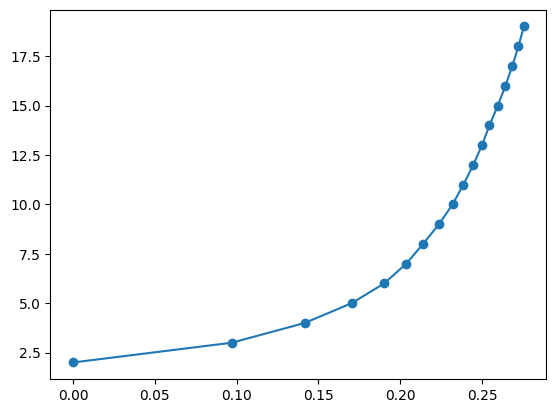

In [10]:
plt.plot(avg_distances,k_range, marker='o', linestyle='-')

In [11]:
mlflow.set_experiment("Meal_Recommender_NN")

with mlflow.start_run():
    k = 5
    metric = "cosine"
    mlflow.log_param("K Param", k)
    mlflow.log_param("Similarity Metric", metric)

    nn = NearestNeighbors(n_neighbors=k,metric=metric)
    nn.fit(ner_vectorized)

    mlflow.sklearn.log_model(nn,"Model")
    model_path = "./Api/SavedModels/knn.pkl" 
    joblib.dump(nn,model_path)
    mlflow.log_artifact(model_path, artifact_path="model")

    print(f"Model saved and logged to MLflow: {model_path}")

Traceback (most recent call last):
  File "c:\Python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1361, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\mlflow\utils\file_utils.py", line 310, in re

Model saved and logged to MLflow: ./Api/SavedModels/knn.pkl


Model Evaluation

In [12]:
%%script false
def precision_at_k(nn,test_set,train_df):
    
    distance,index = nn.kneighbors(test_set)
    recommended_titles = train_df.iloc[index.ravel()]['title'].values
    actual_titles = train_df['title'].values
    print("finding_matches")
    matches = np.array([actual in recommended for actual, recommended in zip(actual_titles, recommended_titles)])
    return np.mean(matches)

precision = precision_at_k(nn,ner_vectorized_test,train_set)
print(f"Precision : {precision}")

Couldn't find program: 'false'


Making A Prediction

In [13]:
def make_predictions(ingredients):
    join_items = " ".join(ingredients)
    numeric_ingredients = vectorizer.transform([join_items])
    distance , indices = nn.kneighbors(numeric_ingredients)
    receipe = dataset.iloc[indices[0][0]]
    receipe = {
        "Title":receipe["title"],
        "Ingredients":receipe["ingredients"],
        "Req":receipe["NER"],
        "source":receipe["link"],
    }
    return receipe
print(make_predictions(["Flour","Salt","Potato"]))


{'Title': 'Kluski(Polish Dumplings)  ', 'Ingredients': '["1 large raw potato", "1/8 tsp. salt", "flour"]', 'Req': ['potato', 'salt', 'flour'], 'source': 'www.cookbooks.com/Recipe-Details.aspx?id=610555'}
